<a href="https://colab.research.google.com/github/hyunyongPark/Recommendation/blob/master/DeepAutoEncoder_Simple_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preparation

In [3]:
def read_process(filname, sep="\t"):
    col_names = ["user", "item", "rate", "st"]
    df = pd.read_csv(filname, sep=sep, header=None, names=col_names, engine='python')
    df["user"] -= 1
    df["item"] -= 1
    for col in ("user", "item"):
        df[col] = df[col].astype(np.int32)
    df["rate"] = df["rate"].astype(np.float32)
    return df

def get_data100k():
    global PERC
    df = read_process("/content/gdrive/My Drive/recommend_practice/GraphRec/GraphRec-master/ml100k/u.data", sep="\t")
    rows = len(df)
    df = df.iloc[np.random.permutation(rows)].reset_index(drop=True)
    split_index = int(rows * PERC)
    df_train = df[0:split_index]
    df_test = df[split_index:].reset_index(drop=True)
    return df , df_train, df_test

PERC=0.9
df , df_train, df_test = get_data100k()

In [4]:
df_train.to_csv('/content/gdrive/My Drive/recommend_practice/movie_train.csv')
df_test.to_csv('/content/gdrive/My Drive/recommend_practice/movie_test.csv')

### Create a Matrix of Interactions

In [5]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user', 
                                 columns = 'item', 
                                 values  = 'rate').fillna(0)
users_items_matrix_df.head(10)

item,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.0,2.0,4.0,1.0,3.0,3.0,5.0,4.0,2.0,1.0,2.0,2.0,3.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,0.0,4.0,2.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,3.0,0.0,4.0,5.0,3.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_matrix_df.shape

(943, 1682)

In [ ]:
users_items_matrix_df.values.mean()

0.222546

## Model

In [6]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

In [7]:
def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='relu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='relu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='relu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='relu', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [8]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [9]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [10]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss = root_mean_squared_error)
    
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 1682)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               861696    
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 1682)              862866    
Total params: 1,987,474
Trainable params: 1,987,474
Non-trainable params: 0
____________________________________________

### Train Model

In [11]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/50
14/14 [==============================] - 0s 34ms/step - loss: 0.9194 - val_loss: 0.9151
Epoch 2/50
14/14 [==============================] - 0s 23ms/step - loss: 0.8898 - val_loss: 0.8984
Epoch 3/50
14/14 [==============================] - 0s 25ms/step - loss: 0.8621 - val_loss: 0.8651
Epoch 4/50
14/14 [==============================] - 0s 23ms/step - loss: 0.8385 - val_loss: 0.8511
Epoch 5/50
14/14 [==============================] - 0s 24ms/step - loss: 0.8223 - val_loss: 0.8412
Epoch 6/50
14/14 [==============================] - 0s 24ms/step - loss: 0.8151 - val_loss: 0.8358
Epoch 7/50
14/14 [==============================] - 0s 23ms/step - loss: 0.8105 - val_loss: 0.8318
Epoch 8/50
14/14 [==============================] - 0s 23ms/step - loss: 0.8081 - val_loss: 0.8280
Epoch 9/50
14/14 [==============================] - 0s 24ms/step - loss: 0.8052 - val_loss: 0.8275
Epoch 10/50
14/14 [==============================] - 0s 24ms/step - loss: 0.8014 - val_loss: 0.8239
Epoch 11/

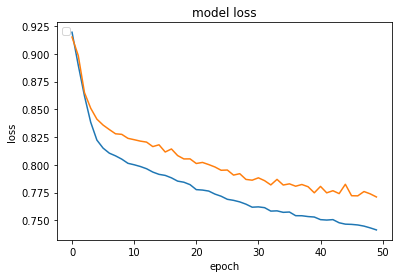

In [12]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [21]:
# Predict new Matrix Interactions, set score zero on visualized games   새로운 매트릭스 상호작용을 예측하고 시각화 된 게임에서 점수를 0으로 설정
new_matrix1 = model.predict(users_items_matrix_df.values)

In [25]:
new_matrix1

array([3.836019  , 2.656625  , 1.9071082 , 1.3809909 , 2.092391  ,
       3.9380777 , 4.0926075 , 1.2005919 , 0.7058463 , 3.5777543 ,
       1.8092122 , 1.4517025 , 4.148673  , 2.5433521 , 2.543954  ,
       2.8946729 , 1.138746  , 4.14077   , 0.44896004, 1.0997931 ,
       2.017525  , 2.1742768 , 2.5931363 , 2.0852175 , 1.8214465 ,
       3.4791794 , 0.9407265 , 1.4158584 , 1.0592942 , 1.3493695 ,
       0.8078468 , 1.6883018 , 1.404322  , 1.040004  , 1.284147  ,
       0.73200655, 1.3586794 , 1.7140784 , 1.2886673 , 1.4426539 ,
       1.1169449 , 2.9612072 , 3.805422  , 3.018479  , 1.6613032 ,
       1.6248795 , 1.59638   , 1.320585  , 1.8906147 , 0.7374728 ,
       0.7380683 , 1.8206747 , 0.9426168 , 2.7926245 , 0.7667552 ,
       3.0185084 , 2.5751562 , 3.5249758 , 4.410034  , 3.450522  ,
       1.1026947 , 3.2324467 , 2.3808928 , 3.4537656 , 1.7355549 ,
       2.1069272 , 0.8282027 , 1.4701285 , 1.9936295 , 2.0102408 ,
       1.0460063 , 2.3297555 , 1.3115395 , 2.2264671 , 1.77429

In [ ]:
# converting the reconstructed matrix back to a Pandas dataframe   재구성 된 행렬을 다시 Pandas 데이터 프레임으로 변환 
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,0,1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,...,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.004948,-0.002395,0.000945,-0.005983,-0.006055,0.008502,0.002291,-0.001835,0.005529,-0.001086,-0.002553,-0.007373,-0.002791,0.002256,-0.002598,0.006398,0.008278,-0.000103,0.006245,0.007516,0.000431,-0.003938,0.013289,-0.001198,0.029778,0.015375,0.009976,0.028352,0.012085,-0.001122,-0.006855,0.001650,-0.010186,-0.004507,0.010736,0.002181,0.001236,-0.005442,-0.008117,-0.023881,...,0.010871,0.003512,-0.000397,0.001520,0.000499,4.081055e-03,-0.007950,0.005960,-0.004659,-0.000233,0.009326,-0.002885,0.001004,-0.001965,0.000825,0.004400,0.000448,0.009401,0.009495,0.002691,0.004515,-0.003447,0.000617,-0.001098,0.006608,0.006653,-0.003499,-0.005276,-0.006083,-0.004478,-0.001597,0.004078,-0.005012,-0.016363,-0.003346,-0.019370,0.003696,-0.003784,-0.020584,-0.001663
1,-0.001570,0.002315,0.000883,0.005008,-0.000796,0.010940,-0.000135,0.001179,0.017183,0.002571,0.001908,-0.005836,0.003174,-0.004907,-0.003950,-0.010009,0.005218,-0.005853,0.007080,0.002417,-0.001485,-0.001495,0.012504,-0.008780,0.005581,-0.001737,0.006390,0.011454,0.015665,0.011645,0.001038,0.003616,-0.025999,-0.003288,0.049361,0.002268,-0.000008,0.003563,0.002243,-0.001657,...,0.001712,0.005591,-0.001583,-0.004931,0.012945,-1.849586e-03,0.005856,0.000021,0.006769,0.007983,0.008881,0.005916,0.003390,0.006951,-0.010159,-0.001239,0.003836,-0.012675,-0.005849,0.008875,-0.004281,0.002856,0.009518,-0.003498,0.003101,-0.001866,0.004840,-0.001606,-0.006008,-0.002529,0.006047,0.008320,-0.000712,0.018524,-0.000279,0.016907,-0.006205,0.001508,0.047682,0.004299
2,0.001393,-0.003861,-0.001158,0.015585,-0.012763,0.017155,0.003741,0.020705,-0.001601,-0.007158,0.003702,-0.007607,0.014424,0.005361,0.000683,0.003487,0.003219,-0.002843,0.001349,0.008623,0.006281,0.003409,0.036382,-0.002504,0.057566,0.049971,0.045263,0.037226,0.040821,0.009839,0.002711,0.010308,-0.017863,0.000051,0.021329,0.016306,0.010270,0.006367,-0.003290,0.013374,...,0.000872,0.008228,-0.006434,-0.002439,0.017880,1.077025e-03,-0.000566,-0.001562,0.012536,-0.020264,0.024075,-0.000760,0.003688,0.007196,-0.006560,-0.006092,-0.007894,-0.004091,0.010039,0.016516,0.016844,-0.025142,-0.004568,-0.000435,-0.002516,0.044442,-0.000056,0.003763,-0.004999,0.000288,-0.007318,0.000750,-0.001113,0.023188,-0.003599,-0.003605,-0.005357,-0.018302,-0.058756,-0.000832
3,-0.004553,0.002395,-0.003318,-0.002454,-0.000901,0.001156,0.000778,-0.001044,0.001178,-0.000330,0.000480,-0.002080,0.003358,-0.007015,-0.007743,0.000107,-0.003075,-0.004592,-0.001425,0.003681,-0.004717,-0.009668,0.014483,0.003864,0.012878,0.003288,-0.000253,0.007356,0.009393,-0.000197,-0.000458,0.000004,-0.008602,0.000348,-0.005274,-0.004709,0.004168,0.002521,0.002339,-0.000389,...,0.000281,0.012256,-0.003826,-0.003027,-0.000417,5.108304e-07,-0.001077,0.007962,0.002481,0.000727,0.009446,0.001150,0.004471,-0.000342,0.001394,-0.001541,-0.004104,0.003206,0.000302,0.008298,-0.003369,0.001846,0.009453,0.003203,0.002448,0.001459,0.003458,-0.001322,-0.005986,-0.004283,0.001354,-0.001422,-0.000483,-0.004809,0.004213,-0.004051,0.003040,0.002471,0.010305,-0.004691
4,-0.003711,0.001038,-0.000984,0.000864,0.004265,0.002974,0.006067,-0.000655,0.005833,-0.001420,-0.001548,-0.001809,0.004966,-0.005446,-0.005251,0.001883,-0.000170,-0.005441,-0.004196,0.001201,-0.000834,-0.004188,0.014630,0.003383,0.014584,0.009691,0.006038,0.011293,0.011659,-0.002698,0.002701,0.000059,-0.007968,0.002238,-0.011397,-0.002049,-0.000391,0.001625,0.001400,-0.000887,...,0.001072,0.008782,-0.002176,0.001136,0.000873,9.395073e-04,0.003120,-0.001155,-0.000550,0.000831,0.008617,0.002688,0.002963,-0.003304,-0.

In [ ]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())   # 예측평점의 범위

-0.55666584 1.4259156


In [ ]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .join(df_content.set_index('content_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'game']]
    
    return df_rec[df_rec.score > 0]

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

In [ ]:
# Games previously purchased by the user   사용자가 이전에 구매 한 게임
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2057,1.0,Half-Life 2 Episode One
2059,1.0,Half-Life 2 Lost Coast


In [ ]:
# Recommended User Games  유저에게 게임 추천
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
2058,0.269709,Half-Life 2 Episode Two
2056,0.234599,Half-Life 2 Deathmatch
978,0.149333,Counter-Strike Source
2062,0.143417,Half-Life Deathmatch Source
3197,0.126299,Portal 2
2457,0.105088,Left 4 Dead 2
1126,0.087011,Day of Defeat Source
2064,0.082528,Half-Life Source
1328,0.080767,Dota 2


Recommender for **user_id = 1319**. This user prefers games in the same line as the RPG or strategy

In [ ]:
# Games previously purchased by the user
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
173,1.0,Age of Empires II HD Edition
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4626,1.0,Total War ATTILA
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
4631,1.0,Total War SHOGUN 2
4328,1.0,The Elder Scrolls V Skyrim


In [ ]:
# Recommended User Games
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
4330,0.290869,The Elder Scrolls V Skyrim - Dragonborn
3792,0.176744,Sid Meier's Civilization V
3837,0.133543,Skyrim High Resolution Texture Pack
1490,0.120577,Empire Total War
3793,0.118183,Sid Meier's Civilization V Brave New World
1667,0.094356,Fallout New Vegas
1328,0.090616,Dota 2
3502,0.086305,Ricochet
4630,0.085074,Total War ROME II - Emperor Edition
